# About This Notebook

This notebook takes in data from https://www.reddit.com/r/winemaking/ via the Push Shift API found at www.pushshift.io

This notebook consists of five steps of initial data retrieval and preprocessing for a Natural Language Processing Project. 

The project at large will intake data from two different subreddits (from www.Reddit.com), clean and process the data, explore the data for relationships, create and manipulate features and then model to produce a predictive classification model. 

This notebook will begin the process described above through the following steps: 

Step 1: Data Retrieval - Is the process of pulling the data from Reddit using the Pushshift API.

Step 2: Initial Analysis for Cleaning - Which will analyze unique values, indexes and summary info. 

Step 3: Preprocessing / Cleaning - Will reduce the amount of features being processed, handle duplicate values, and eliminate null values. 

Step 4: Preliminary EDA - Will conduct an initial exploration of the data to analyze unique values in greater detail, initially explore the possibility of outliers in the data and look into features that may be interesting overall but that may not make it into the advanced EDA and modeling process. 

Step 5: Preparing DF for Text Analysis - This process will reduce feature columns to just those that will be used in advanced EDA and modeling. It will then save this file to CSV for the purpose of importing into another notebook focused on advanced EDA and feature creation. 

About r/winemaking subreddit:

* Created in November of 2008 it is a community for people interested in viticulture, winemaking and other fermented beverages. 
* At the time of this project there are around 39,000 members. 
* You can find more information about this community on their Reddit Wiki https://www.reddit.com/r/winemaking/wiki/index
* Here you will find information abou the moderators, links to winemaking tips and a list of places to source grapes. 

### Importing Libraries

In [1]:
import requests
import time
import pandas as pd
import numpy as np
import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Step 1

# Data Retrieval

### Pulling in Data Using Pushift API

In [2]:
# defining url for pushshift apo
url = 'https://api.pushshift.io/reddit/submission/search'
# creating an empty list to collect the dataframe lists
dfs = []

# number of loops that will be made. Each loop pulls a new set of posts.
loops = 40

params = {
        'subreddit': 'winemaking', 
        'size': 100,
#         'before' :
        }


#defining the time in which I start the loop.
start_time = time.time()

#create for loop that sets the current time for the sake of ensuring we are not scraping too fast or taking too many of the sites reasoureces. 
for i in range(loops):
    
    current_time = time.time()
    #requesting data
    res = requests.get(url, params) #getting request
    print(f'res {i+1} code: ', res.status_code) #printing request status to ensure it went through securely
    
    data = res.json() #using json to read
    posts = data['data'] #indexing into 'data' from json dictionary and list of dictionaries
    posts_df = pd.DataFrame(posts)
    dfs.append(posts_df) #create dataframe from 'data' dictionary
        
        
    # get oldest post time and use as before parameter in next request
    params['before'] = posts_df['created_utc'].min()#adding 'before' parameter to params dictionary
        
    #created lower limit of 1 second to ensure we are abiding by resource conventions.
    time.sleep(3)

# creating a dataframe by concatetinating all of the df lists created by the loop    
reddit_posts = pd.concat(dfs)

res 1 code:  200
res 2 code:  200
res 3 code:  200
res 4 code:  200
res 5 code:  200
res 6 code:  200
res 7 code:  200
res 8 code:  200
res 9 code:  200
res 10 code:  200
res 11 code:  200
res 12 code:  200
res 13 code:  200
res 14 code:  200
res 15 code:  200
res 16 code:  200
res 17 code:  200
res 18 code:  200
res 19 code:  200
res 20 code:  200
res 21 code:  200
res 22 code:  200
res 23 code:  200
res 24 code:  200
res 25 code:  200
res 26 code:  200
res 27 code:  200
res 28 code:  200
res 29 code:  200
res 30 code:  200
res 31 code:  200
res 32 code:  200
res 33 code:  200
res 34 code:  200
res 35 code:  200
res 36 code:  200
res 37 code:  200
res 38 code:  200
res 39 code:  200
res 40 code:  200


In [3]:
reddit_posts.shape

(4000, 81)

# Step 2
# Initial Analysis for Cleaning

### Initial Analysis of Unique Values (Prior to Cleaning)
* Note, I had to scrape 1,000 more values from the wine subbreddit than I did the homebrewing subreddit just to get close to the amount of unique posts. Oddly I cam up with more unique authors but less unique posts. 

#### 4000 unique post id's 

In [4]:
unique_ids = reddit_posts['id'].nunique()
unique_ids

4000

#### 2139 unique authors

In [5]:
unique_authors = reddit_posts['author'].nunique()
unique_authors

2138

#### 1943 unique posts

In [6]:
unique_posts = reddit_posts['selftext'].nunique()
unique_posts

1937

#### Percentage of Unique Posts to Unique IDs
* The percentage of unique posts in winemaking is much smaller than the percentage of unique posts in homebrewing. 

In [7]:
unique_posts / unique_ids

0.48425

________________________
## Column and Index Check

### Checking column index

In [8]:
reddit_posts.columns;

### Checking row index
* row index appears to be repeating similarly to how it was in the beer api_pull notebook. 
* It is due to the for-loop that I ran to pull from API. 
* going to reset index

In [9]:
reddit_posts.index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
            ...
            90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
           dtype='int64', length=4000)

In [10]:
reddit_posts.reset_index(inplace = True, drop = True)

In [11]:
reddit_posts.index

RangeIndex(start=0, stop=4000, step=1)

______________________

### Summary Info

In [12]:
reddit_posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 81 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   all_awardings                  4000 non-null   object 
 1   allow_live_comments            4000 non-null   bool   
 2   author                         4000 non-null   object 
 3   author_flair_css_class         0 non-null      object 
 4   author_flair_richtext          3969 non-null   object 
 5   author_flair_text              0 non-null      object 
 6   author_flair_type              3969 non-null   object 
 7   author_fullname                3969 non-null   object 
 8   author_patreon_flair           3969 non-null   object 
 9   author_premium                 3797 non-null   object 
 10  awarders                       4000 non-null   object 
 11  can_mod_post                   4000 non-null   bool   
 12  contest_mode                   4000 non-null   b

# Step 3

# Preprocessing / Cleaning

## Create new Wine_1 dataframe with reduced columns

In [13]:
wine_1 = reddit_posts[['id', 'created_utc', 'title', 'selftext', 'author', 'score', 'num_comments', 'subreddit']]

In [14]:
wine_1.head()

,id,created_utc,title,selftext,author,score,num_comments,subreddit
0,ktkbti,1610168355,Multitasking- I know V8s are supposed to be he...,,CounterReloj101,1,0,winemaking
1,ktitve,1610162643,What is the name of a convex plug like that ? ...,,Crepeas,1,0,winemaking
2,ktfzsp,1610152734,"Blackberry wine, now 1.5 years old. First brew...",,Double_Criticism4900,2,2,winemaking
3,kt9m9f,1610133809,The oldest alcoholic drinks is displayed in th...,,-Darttz-,2,0,winemaking
4,kt9l6i,1610133735,Rondo Port/Fortified wine?,"Hey gang, I will be growing Rondo grapes in th...",AinslieBM,1,0,winemaking


### Checking for Duplicates
* There are none according to .duplicated()
* however, value_counts on 'selftext' reveal a few duplicated 'selftext' values.

In [15]:
wine_1.duplicated().value_counts()

False    4000
dtype: int64

There are a few removed and deleted values. Not as many as in the homebrewing data. 

In [16]:
wine_1['selftext'].value_counts().head()

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 1943
[removed]                                                                         

### Eliminating 'removed' values

In [17]:
count = 0
for item in wine_1['selftext']:
    if item == '[removed]':
        count += 1
print(count)

76


In [18]:
wine_1 = wine_1[wine_1['selftext'] != '[removed]']

In [19]:
count = 0
for item in wine_1['selftext']:
    if item == '[removed]':
        count += 1
print(count)

0


### Eliminating 'deleted' values

In [20]:
count = 0
for item in wine_1['selftext']:
    if item == '[deleted]':
        count += 1
print(count)

30


In [21]:
wine_1 = wine_1[wine_1['selftext'] != '[deleted]']

In [22]:
count = 0 
for item in wine_1['selftext']:
    if item == '[deleted]':
        count += 1
print(count)

0


Resetting index again to account for dropped values

In [23]:
wine_1.reset_index(inplace = True, drop = True)

In [24]:
wine_1.index

RangeIndex(start=0, stop=3894, step=1)

In [25]:
wine_1.columns

Index(['id', 'created_utc', 'title', 'selftext', 'author', 'score',
       'num_comments', 'subreddit'],
      dtype='object')

### Eliminating duplicates
* Not as many as in the homebrewing data but a few exist. 

In [26]:
wine_1 = wine_1.drop_duplicates('selftext', keep = 'first').reset_index(drop = True)

In [27]:
wine_1.columns

Index(['id', 'created_utc', 'title', 'selftext', 'author', 'score',
       'num_comments', 'subreddit'],
      dtype='object')

Checking duplicates. No more exist

In [28]:
wine_1['selftext'].value_counts().nlargest();

In [29]:
wine_1.nunique()

id              1936
created_utc     1936
title           1912
selftext        1935
author          1268
score             21
num_comments      49
subreddit          1
dtype: int64

### Checking and Managing Null Values
* 1 null value in selftext. I will drop the row.  

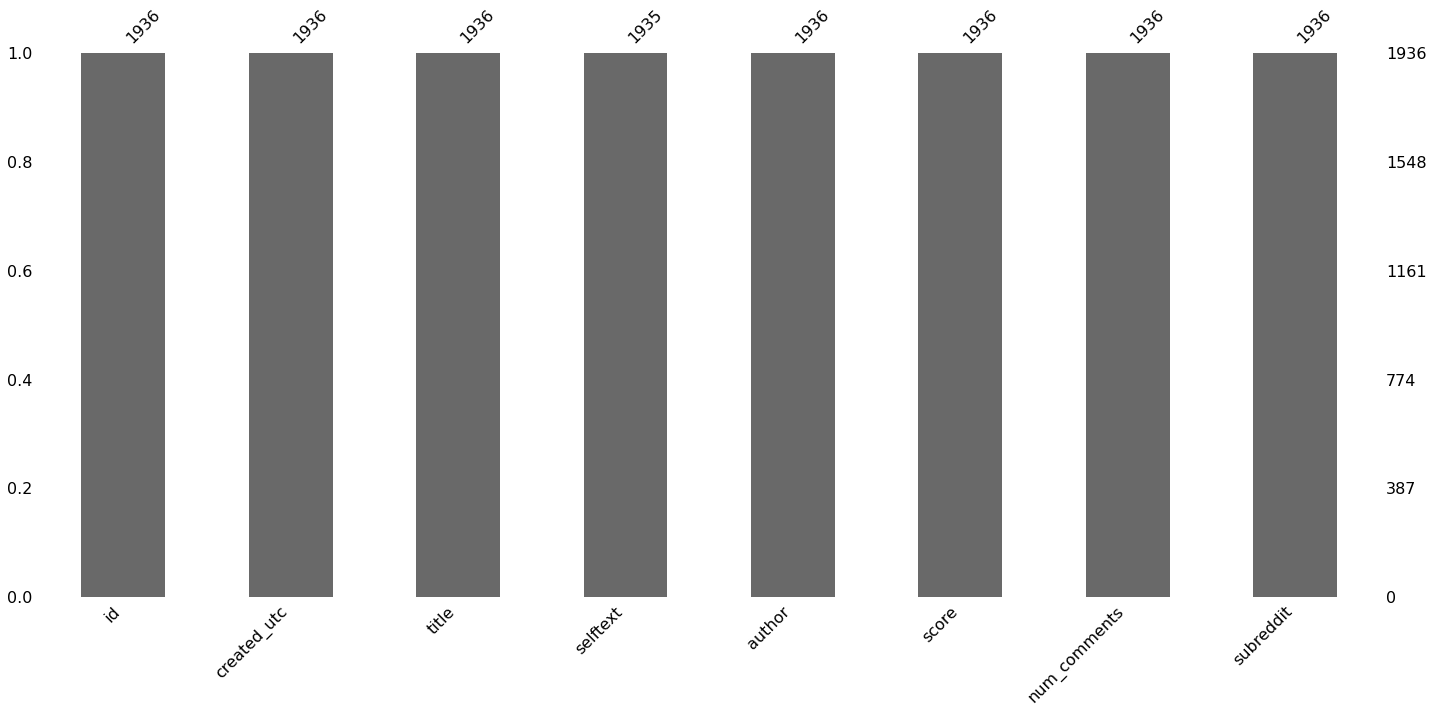

In [30]:
msno.bar(wine_1);

In [31]:
wine_1 = wine_1.dropna()

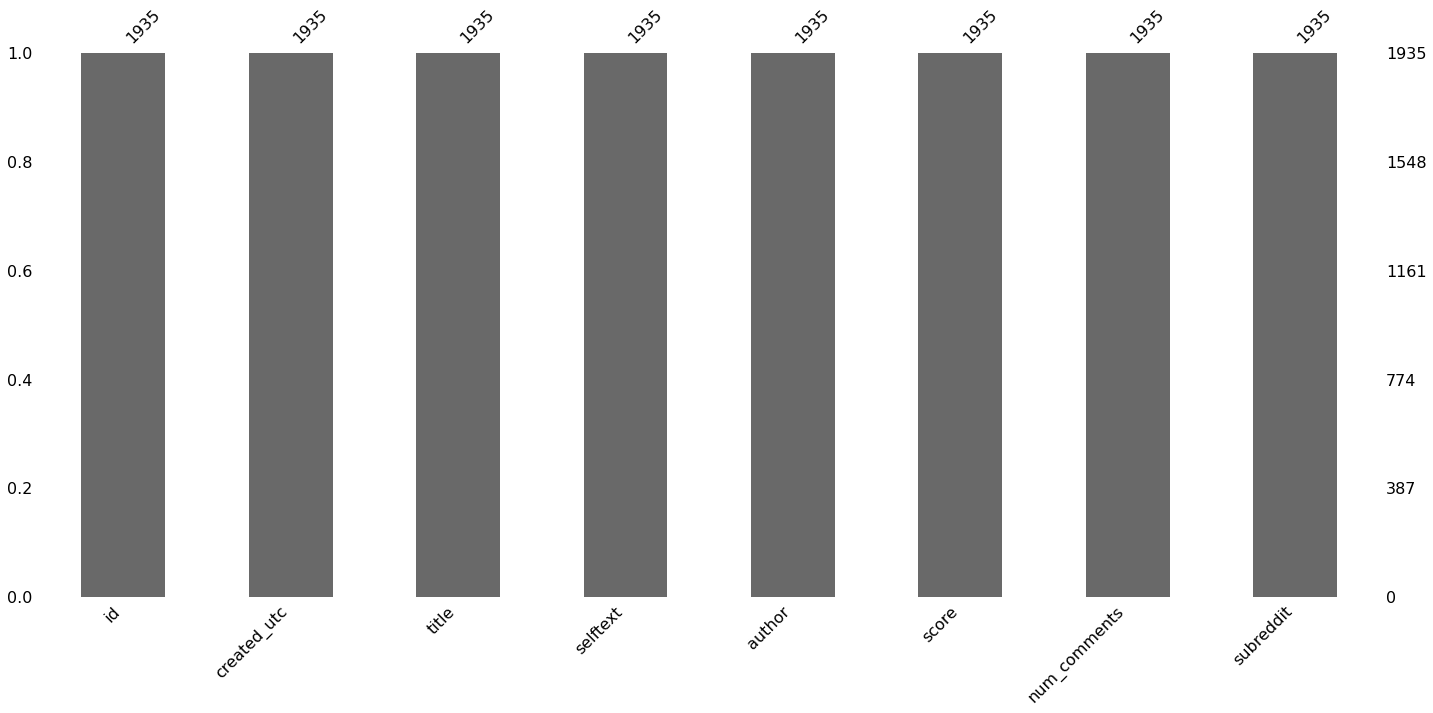

In [32]:
msno.bar(wine_1);

### Checking Post Lengths
To ensure there is content in every post

In [33]:
# There are no posts that have less than 5 characters
for post in wine_1['selftext']:
    if len(post) < 5:
        print(post)

Creating a list of post lengths to add to a histogram

In [34]:
post_lengths = []
for post in wine_1['selftext']:
    post_lengths.append(len(post))
len(post_lengths) # ensuring I got all the values. 

1935

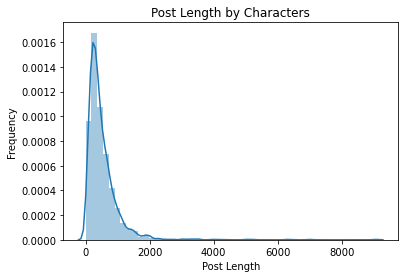

In [35]:
sns.distplot(post_lengths).set_title('Post Length by Characters')

plt.xlabel('Post Length')
plt.ylabel('Frequency');

# Step 4
# Preliminary EDA
* This Exploratory Data Analysis is being conducted for the purpose of getting to know the data that surrounds the target data and predictor variables. It is also being utulized to identify any useful and interesting statistics or relationships that exist outside of predictive modeling and the exploratory process that preceeds modeling. 

### Unique Author / Unique Post Analysis

Unique Authors

In [36]:
unique_authors = wine_1['author'].nunique()
unique_authors

1267

Unique Posts

In [37]:
unique_posts = wine_1['selftext'].nunique()
unique_posts

1935

Authors of Multiple Posts
* There are 313 repeat authors of 1264 unique authors. 
* Almost 33% percent of authors are multiple posters. 


In [38]:
author_multi = wine_1['author'].value_counts() > 1

In [39]:
author_multi.value_counts()

False    959
True     308
Name: author, dtype: int64

In [40]:
313 / 951

0.3291272344900105

In [41]:
total_multi_posts = wine_1['author'].value_counts().nlargest(313).sum()
total_multi_posts

981

In [42]:
total_multi_posts / unique_posts

0.5069767441860465

_________________________________________________

#### Analyzing Posts with Multiple Comments

In [43]:
multi_comment_count = wine_1['num_comments'][wine_1['num_comments'] > 1].count()
multi_comment_count

1613

#### Boxplot for Number of Comments (Prior to Eliminating Outliers if Necessary)

Box plot showing distribution of the comment counts within and outside of the interquartile range. 

The whisker for the quartile is the vertical grey line. It is the 75 percentile plus 1.5 times the interquartile range. The black dots past that whisker are considered outliers. There a few outliers here but the variance and number is much smaller than what existed in the Homebrew data. Further data cleaning may not be needed. 

That being said, in alignment with the Homebrew data, the vast majority of posts receiving multiple comments are located closer to zero. The entire IQR is located below 10.  

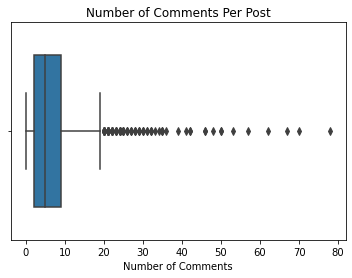

In [44]:
sns.boxplot(wine_1['num_comments'], width = .7, whis = 1.5).set_title('Number of Comments Per Post')

plt.xlabel('Number of Comments');

83 percent of posts had more than 1 comment. 
* This is slightly more discerning than homebrewing subreddit which had 94%. 

In [45]:
multi_comment_count / unique_posts

0.8335917312661498

In [46]:
wine_1.describe()

,created_utc,score,num_comments
count,1.935000e+03,1935.000000,1935.000000
mean,1.593243e+09,1.280103,6.587080
std,9.855658e+06,2.097690,7.100588
min,1.572659e+09,0.000000,0.000000
25%,1.586071e+09,1.000000,2.000000
50%,1.594349e+09,1.000000,5.000000
75%,1.601217e+09,1.000000,9.000000
max,1.610168e+09,52.000000,78.000000


If a post received less than 2 comments it was in the bottom 25% in terms of number of comments. The Homebrew data had a larger threshold for Q1 at 5 comments. If you received over 9 comments you were in the highest 25% of comment receivers. Again, this is lower than threshold the Homebrew data which saw a Q3 threshold of 16. 

### Analyzing Five Largest Comment Achievers

In [47]:
wine_1['num_comments'].nlargest()

258     78
224     70
1320    67
1725    62
1913    57
Name: num_comments, dtype: int64

Checking to see if anything odd exists in top give comment values. 

In [48]:
wine_1.loc[[215, 181, 1277, 1682, 1870], 'selftext']

215     Anyone like to recommend filtering equipment f...
181     Hello everyone, I have a wine question since I...
1277    Just starting to making my own wine for the ve...
1682    I can't seem to find Montrachet, K1-V1116 or Q...
1870    im poor and have crap tons of oranges that are...
Name: selftext, dtype: object

Nothing seems unusal. I will leave comments the way they are. 

### Analyzing Score

In [49]:
wine_1['score'].nlargest()

1409    52
906     46
948     21
1416    20
1762    19
Name: score, dtype: int64

Posts that score over 1 (the base score) account for nearly 9 percent of posts. A fairly small fraction of posts actually get scored. This is inline with the Homebrew data which received a score in about 7 percent of posts. 

In [50]:
score_over_1_count = wine_1['score'][wine_1['score'] > 1].count()
score_over_1_count

140

None of the top five scores (below) seem out of the ordinary. 

In [51]:
wine_1.loc[[1366, 863, 905, 1373, 1719], 'selftext']

1366    Hi all, I’m new to this sub and this is my fir...
863     Hello all, my gallon batch of blueberry ginger...
905     Hi! I have a question. I have tried to make wi...
1373    I just bought a 1 gallon wine making kit, but ...
1719    Hey everyone! I just wanted to start a thread ...
Name: selftext, dtype: object

In [52]:
score_over_1_count / unique_posts

0.07235142118863049

# Step 5
# Preparing DF for Text Analysis

In [53]:
wine_1.columns

Index(['id', 'created_utc', 'title', 'selftext', 'author', 'score',
       'num_comments', 'subreddit'],
      dtype='object')

In [54]:
wine_1 = wine_1.drop(columns = ['id', 'created_utc', 'author', 'score', 'num_comments'])

In [55]:
wine_1.columns

Index(['title', 'selftext', 'subreddit'], dtype='object')

### Adding title to self text for the purpose of text analysis

In [56]:
wine_1['selftext'] = wine_1['title'] + ' ' + wine_1['selftext']

In [57]:
wine_1['selftext'].head()

0    Multitasking- I know V8s are supposed to be he...
1    Rondo Port/Fortified wine? Hey gang, I will be...
2    How much water should I use? I know this is su...
3    using oak chips i am going to try again at a b...
4    Snow in Rousset les Vignes (Rhône Valley, AOC)...
Name: selftext, dtype: object

In [58]:
wine_1

,title,selftext,subreddit
0,Multitasking- I know V8s are supposed to be he...,Multitasking- I know V8s are supposed to be he...,winemaking
1,Rondo Port/Fortified wine?,"Rondo Port/Fortified wine? Hey gang, I will be...",winemaking
2,How much water should I use?,How much water should I use? I know this is su...,winemaking
3,using oak chips,using oak chips i am going to try again at a b...,winemaking
4,"Snow in Rousset les Vignes (Rhône Valley, AOC)","Snow in Rousset les Vignes (Rhône Valley, AOC)...",winemaking
...,...,...,...
1931,Refractometer Gift Recommendations please?,Refractometer Gift Recommendations please? Hi ...,winemaking
1932,"Wine, Wine Making, Storage and Transport in a ...","Wine, Wine Making, Storage and Transport in a ...",winemaking
1933,Can I cold crash in a chest freezer?,Can I cold crash in a chest freezer? I still h...,winemaking
1934,Wine finishes fine but initial taste is watery,Wine finishes fine but initial taste is watery...,winemaking


In [59]:
# found a marketing add above that I didn't find previously. I am going to remove it. 
wine_1.drop(1, inplace = True)

In [60]:
wine_1.reset_index(inplace = True, drop = True)

In [61]:
wine_1

,title,selftext,subreddit
0,Multitasking- I know V8s are supposed to be he...,Multitasking- I know V8s are supposed to be he...,winemaking
1,How much water should I use?,How much water should I use? I know this is su...,winemaking
2,using oak chips,using oak chips i am going to try again at a b...,winemaking
3,"Snow in Rousset les Vignes (Rhône Valley, AOC)","Snow in Rousset les Vignes (Rhône Valley, AOC)...",winemaking
4,Managing sulphur in filled barrels,Managing sulphur in filled barrels Is there an...,winemaking
...,...,...,...
1929,Refractometer Gift Recommendations please?,Refractometer Gift Recommendations please? Hi ...,winemaking
1930,"Wine, Wine Making, Storage and Transport in a ...","Wine, Wine Making, Storage and Transport in a ...",winemaking
1931,Can I cold crash in a chest freezer?,Can I cold crash in a chest freezer? I still h...,winemaking
1932,Wine finishes fine but initial taste is watery,Wine finishes fine but initial taste is watery...,winemaking


# Saving new df to CSV

In [62]:
wine_1.to_csv('../data/01_wine.csv', index = False)